<a href="https://colab.research.google.com/github/ZhilaAghajari/classification_methods_comparision/blob/main/Classification_Comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cifar data set
!gdown --id 1fxiOJsKcHLaTzuZ4shFN5D9ZtXJh-N24

Downloading...
From: https://drive.google.com/uc?id=1fxiOJsKcHLaTzuZ4shFN5D9ZtXJh-N24
To: /content/cifar-10-python.tar.gz
170MB [00:01, 92.2MB/s]


In [ ]:
# Extracting the Cifar data set
import tarfile
fname = "cifar-10-python.tar.gz"
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()


In [ ]:
# MNIST data set
!gdown --id 1vJxb2GHtfZXumCjL4JfnnlU4bp1D1SWX
!gdown --id 1hq9Q9B6fvUPyazzrdnnqSy5JO7sAuUg4

Downloading...
From: https://drive.google.com/uc?id=1vJxb2GHtfZXumCjL4JfnnlU4bp1D1SWX
To: /content/MNIST_data.txt
100% 48.0/48.0 [00:00<00:00, 79.2kB/s]
Downloading...
From: https://drive.google.com/uc?id=1hq9Q9B6fvUPyazzrdnnqSy5JO7sAuUg4
To: /content/cho.txt
100% 36.3k/36.3k [00:00<00:00, 28.1MB/s]


In [ ]:
!gdown --id 1CACpD4cXHJCHDUlyS0Yih-ScP568eJvi

Downloading...
From: https://drive.google.com/uc?id=1CACpD4cXHJCHDUlyS0Yih-ScP568eJvi
To: /content/iyer.txt
100% 33.5k/33.5k [00:00<00:00, 57.4MB/s]


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import pickle
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, \
							precision_score, f1_score
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

from keras.utils import to_categorical
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score



In [ ]:
#Cho data set
!gdown --id 1k7KnufxjWEVix32WXFPzHZgpDxdMOMfR

Downloading...
From: https://drive.google.com/uc?id=1k7KnufxjWEVix32WXFPzHZgpDxdMOMfR
To: /content/cho.txt
100% 36.3k/36.3k [00:00<00:00, 61.3MB/s]


In [ ]:
def visualize(data, cluster, title):
  pca = PCA(n_components=2)
  pca_data = pca.fit_transform(data)
  plt.scatter(x =pca_data[:, 0], y = pca_data[:,1], c=clusters)
  plt.title(title)

In [ ]:
def spliting_train_test(dataset):
  if dataset =='MNIST':
    (train,train_labels),(test,test_labels) = tf.keras.datasets.mnist.load_data()
  elif (dataset =='CHO'):
    data = pd.read_csv('./cho.txt', sep = '\t', header = None)
    # x = data.iloc[:,:-1]
    # y = data.iloc[:, 1]
    y = data.iloc[:,1]
    x = data.iloc[:,2:]
    train, test, train_labels, test_labels = train_test_split(x, y, test_size = 0.3, random_state=42)
  
  elif (dataset =='IYER'):
    data = pd.read_csv('./iyer.txt', sep = '\t', header = None)
    # x = data.iloc[:,:-1]
    # y = data.iloc[:, 1]
    y = data.iloc[:,1]
    x = data.iloc[:,3:]
    train, test, train_labels, test_labels = train_test_split(x, y, test_size = 0.3, random_state=42)
  
  elif (dataset == 'CIFAR'):
    # train_dic = {}
    train = []
    for i in range(5):
      file = './cifar-10-batches-py/data_batch_'+str(i+1)
      with open(file, 'rb') as fo:
          dic = pickle.load(fo, encoding='bytes')
          if train == []:
            # train = np.array(dict[b'data'][0:dict[b'data'].shape[0], 0:dict[b'data'].shape[1]])
            # print(train.shape)
            # train= (dic[b'data']).reshape((dic[b'data'].shape[0], 32,32, 3), order='F')
            train = (dic[b'data']).reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
      
            train_labels = np.array(dic[b'labels'])
          else:
            # concatinate the new batch to the train set ..
            train = np.vstack((train, (dic[b'data']).reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")))
            
            train_labels = np.hstack((train_labels, np.array(dic[b'labels'])))

          # train_dic = {**train_dic, **dict}
      
    file = './cifar-10-batches-py/test_batch'
    with open(file, 'rb') as fo:
      test_dic = pickle.load(fo, encoding='bytes')
      # test = (test_dic[b'data']).reshape((test_dic[b'data'].shape[0], 32,32, 3))
      test = (test_dic[b'data']).reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
      test_labels = np.array(test_dic[b'labels'])
  
  return (train, test, train_labels, test_labels)

In [ ]:
def classification(method, train,train_labels,test,test_labels, pca_flag, data_set):
  res_prob = []
  if (method == 'XGboost'):
    # for the 3D data:
    if data_set =='MNIST':
      train = train.reshape(train.shape[0], train.shape[1]*train.shape[2]) #vectorizing the input for XGBoost
      test = test.reshape(test.shape[0], test.shape[1]*test.shape[2])
    # if(len(train.shape ==4)):
    if data_set == 'CIFAR':
      train = train.reshape(train.shape[0], train.shape[1]*train.shape[2]*train.shape[3])
      test = test.reshape(test.shape[0], test.shape[1]*test.shape[2]*test.shape[3])
    
    #dimention reduction using PCA method 
    if pca_flag == True:
      # if len(train[0]<20):
      if data_set == 'CHO':
        n_comp = 3
      else:
        n_comp = 20
      pca = PCA(n_components = n_comp)
      pca.fit(train)
      train = pca.transform(train)
      test = pca.transform(test)
 
    #applying XGBoost model ..
    model = XGBClassifier(max_depth=4) #defult max depth is 3.. #defult n_estimator  = 50
    model.fit(np.asfarray(train), np.asfarray(train_labels)) 
    res = model.predict(np.asfarray(test))
    return res
 
  elif (method =='SVM'):
    # for the 3D data:
    if(len(train.shape)== 3): 
      train = train.reshape(train.shape[0], train.shape[1]*train.shape[2]) #vectorized it for SVM
      test = test.reshape(test.shape[0], test.shape[1]*test.shape[2])
    
    if len(train.shape)==4:
      train = train.reshape(train.shape[0], train.shape[1]*train.shape[2]*train.shape[3])
      test = test.reshape(test.shape[0], test.shape[1]*test.shape[2]*test.shape[3])
    
    #dimention reduction using PCA method 
    if pca_flag == True:
      if len(train[0]<20):
        n_comp = 10
      else:
        n_comp = 20
      pca = PCA(n_components = n_comp)
      pca.fit(train)
      train = pca.transform(train)
      test = pca.transform(test)
 
    #applying SVM model ..
    # model = svm.SVC(decision_function_shape='ovr', kernel='sigmoid', probability = True)
    model = svm.SVC(decision_function_shape='ovr', kernel='sigmoid')
    scores = cross_val_score(model, train, train_labels, cv=10)
    # print('Score: ', scores)
    model.fit(train, train_labels)
    # res = model.predict_proba(test)
    res = model.predict(test)
    print(res)
    return res
  elif (method =='CNN'): # Remmber it won't result good for cho.txt, I guess. so test it
  # create the CNN model     
    # test_labels_t = test_labels[:,:]
    if data_set =='CHO':
      test_labels_t = test_labels[:]
      train_labels = tf.one_hot(train_labels, np.max(train_labels)-np.min(train_labels)+1)
      test_labels = tf.one_hot(test_labels, np.max(test_labels)-np.min(test_labels)+1)
 
 
      model = models.Sequential()
      #hyper parameters .. 
      epochs = 20
      output_num = train_labels.shape[1] #np.max(test_labels)-np.min(test_labels)+1
      n_features = train.shape[1] # set it after doing PCA -- 
      train = train.reshape(train.shape[0],n_features,1)
      test= test.reshape(test.shape[0],n_features,1)
    
      print(train_labels.shape, test_labels.shape)
      print(train.shape, test.shape)
      # model.add(layers.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_features, 1)))
      # model.add(MaxPooling1D(pool_size=2))
      # model.add(Flatten())
      # DNN model
      model.add(layers.Dense(1024, activation='relu',input_shape=(n_features, 1)))
      model.add(layers.Dense(2048, activation='relu',input_shape=(n_features, 1)))
      model.add(Flatten())
      model.add(layers.Dropout(.2))
      model.add(layers.Dense(output_num,activation='softmax'))
    
 
 
    elif data_set =='MNIST':
      test_labels_t = test_labels[:]
      train_labels = tf.one_hot(train_labels, 10)
      test_labels = tf.one_hot(test_labels, 10)
      print(train_labels.shape,test_labels.shape)
      model = models.Sequential()
      train = train.reshape(train.shape[0],28,28,1) # 
      train = train.astype('float32') 
      # train, train_labels = train / 255.0, train_labels / 255.0
      train = train / 255.0
 
      test = test.reshape(test.shape[0],28,28,1)
      test = test.astype('float32')
      # test, test_labels = test / 255.0, test_labels / 255.0
      test, test / 255.0
      
     
      #hyper-parameters
      epochs = 10
      output_num = 10
  
      #explain the layer here ... and in the report 
      model.add(layers.Conv2D(64,(5,5), activation='relu', input_shape=(28, 28,1) ))
      model.add(layers.MaxPooling2D(2,2))
      model.add(layers.Conv2D(128,(5,5), activation='relu'))
      model.add(layers.MaxPooling2D(2,2))
      #we need to flatten the output of maxpooling before giving it to Dense layer 
      model.add(layers.Flatten())
      model.add(layers.Dense(526,activation='relu'))
      model.add(layers.Dropout(0.2))
      model.add(layers.Dense(output_num,activation='softmax'))
    elif data_set =='CIFAR':
      train_labels = tf.one_hot(train_labels, 10)
      test_labels_t = test_labels[:]
      test_labels = tf.one_hot(test_labels, 10)
      model = models.Sequential()
      train = train.reshape(train.shape[0], 32, 32, 3, 1)
      train =train.astype('float32')
      #scaling -- because pixcels are between 0 to 255
      train = train / 255.0
 
      test = test.reshape(test.shape[0], 32, 32, 3, 1)
      test = test.astype('float32')
      test = test / 255.0
 
      #hyper-parameters
      epochs = 10
      output_num = 10
  
      #explain the layer here ... and in the report 
      model.add(layers.Conv3D(64,(3,3,1), activation='relu', input_shape=(32, 32, 3,1) ))
      model.add(layers.MaxPooling3D((2,2,1)))
      model.add(layers.Conv3D(128,(3,3,1), activation='relu'))
      model.add(layers.MaxPooling3D((2,2,1)))
      #explain the layer here ... and in the report
      model.add(layers.Flatten())
      model.add(layers.Dense(128,activation='relu'))
      model.add(layers.Dropout(0.2))
      model.add(layers.Dense(output_num,activation='softmax'))
    
    if data_set == 'CHO':
      model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics=['accuracy'])
    else:
      model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics=['accuracy'])
 
    #training and prediction..
    # model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics=['accuracy'])
    # model.fit(train,train_labels,epochs=epochs,validation_data=(test,test_labels))
    model.fit(train,train_labels,epochs=epochs, batch_size = 16)

    # demonstrate prediction
    res = model.predict(test)
    # print('****')
    # print(res)
    # print(res.shape)
    auc = roc_auc_score(test_labels_t,res,multi_class='ovr',average = 'macro')
    print('AUC value : {0}'.format(auc))
    # res_prob = res
    res = np.argmax(res,axis=1) # so we won't get probabiblity anymore

    return res


In [ ]:
def evaluation(results, labels, result_matrix):
  #accuracy: number of classified correctly/number of all samples
  accurac = (np.asfarray(labels)==results).sum()/len(labels)
  f_score = f1_score(labels,results,average='macro')
  auc = roc_auc_score(labels,result_matrix,multi_class='ovr',average = 'macro')
  rec = recall_score(labels,results,average='macro')
  precis = precision_score(labels,results,average='macro')
  # area under curve .. AUC
  return accurac, rec, precis, f_score, auc

In [ ]:
# set the dataset
data_set = 'CHO'
train, test, train_labels, test_labels = spliting_train_test(data_set)
# if the dataset is CHO I convert it to numpy (because I read it as dataframe)
if data_set == 'CHO':
  train = train.values
  test = test.values
  train_labels = train_labels.values-1
  test_labels = test_labels.values-1
# method = 'CNN'
method = 'SVM'
# method = 'CNN'
pca_flag = False
# print(train.shape[1])
res = classification(method, train,train_labels,test,test_labels, pca_flag, data_set)
# res = np.argmax(res_prob,axis=1) 
result_matrix = np.zeros((test_labels.size,int(np.max(test_labels)-np.min(test_labels))+1))
res_list = [int(i) for i in res.tolist()]
result_matrix[np.arange(len(res_list)),res_list] = 1.0


[4 2 2 2 1 3 1 2 3 0 1 1 1 4 1 4 1 1 4 2 0 1 3 0 1 0 1 1 3 0 3 1 0 2 1 2 0
 1 3 3 0 0 4 0 1 1 3 4 0 1 3 1 1 2 0 1 4 3 0 1 3 4 1 3 4 0 1 2 1 4 1 1 0 0
 1 4 1 1 3 4 0 1 1 4 1 2 4 1 4 1 4 1 4 1 0 3 3 0 0 0 3 4 1 1 3 4 2 1 2 1 1
 0 4 1 1 4]


In [ ]:
res.shape
result_matrix.shape

(116, 5)

In [ ]:
results = evaluation(res, test_labels, result_matrix)
print(results)

(0.6724137931034483, 0.6229405594405594, 0.6248535777947544, 0.6194538300228553, 0.7693812472141738)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(32, 32, 3)


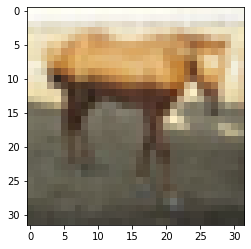

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
data_set = 'CIFAR'
train, test, train_labels, test_labels = spliting_train_test(data_set)
plt.imshow(train[2000])
print(train[0].shape)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
def plot_tnse(x, y):
  tsne_data = TSNE(n_components=2).fit_transform(x)
  plt.scatter(x =tsne_data[:, 0], y = tsne_data[:,1], c=y)
